In [8]:
import os
import shutil
import sys

# --- CONFIGURATION ---
REPO_URL = "https://github.com/filipematos95/ElementalWorld.git"
REPO_NAME = "ElementalWorld"
# ---------------------

# 1. Clone the repo
if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}
else:
    # If it exists, pull latest changes
    %cd {REPO_NAME}
    !git pull
    %cd ..

print("Files restored! You can now run imports.")

# 1. Define the path explicitly
repo_path = f"/content/ElementalWorld"

# 2. Add it to system path if missing
if repo_path not in sys.path:
    sys.path.append(repo_path)
    print(f"Added {repo_path} to sys.path")

# 3. Now try import
from hybridmodel import *
print("Success!")

/content/ElementalWorld
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 2.53 KiB | 107.00 KiB/s, done.
From https://github.com/filipematos95/ElementalWorld
   c181021..1029937  main       -> origin/main
Updating c181021..1029937
Fast-forward
 simulation_notebook.ipynb | 191 ++++++++++++++++++++++++++++++----------------
 1 file changed, 125 insertions(+), 66 deletions(-)
/content
Files restored! You can now run imports.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import ecosystem_plotting as plot

tf.random.set_seed(42)
np.random.seed(42)

# --- 1. CONFIGURATION ---
H, W = 100, 100
MAX_AGENTS = 500000  # High limit for safety
N_STEPS = 250


# Define your niche for Spp0
spp0_niche = {
    "center": [0.60, 0.20, 0.1, 0.05, 0.05],
    "left":   [0.2, 0.1, 0.07, 0.02, 0.02],  # Sensitive to depletion (Left side steep)
    "right":  [0.1, 0.1, 0.07, 0.02, 0.02]   # Tolerant to excess (Right side wide)
}

NICHE_CENTERS = np.array([spp0_niche["center"]], dtype=np.float32)
NICHE_LEFT    = np.array([spp0_niche["left"]], dtype=np.float32)
NICHE_RIGHT   = np.array([spp0_niche["right"]], dtype=np.float32)

model = HybridEcosystem(
    height=50, width=50, max_agents=10000,
    niche_centers=NICHE_CENTERS,
    niche_left=NICHE_LEFT,
    niche_right=NICHE_RIGHT,
    growth_rate=1,
    respiration_rate=0.01,
    turnover_rate=0.02,
    mineralization_rate=0.05,
    seed_cost=0.3,
    seed_mass=0.05,
    K_biomass=1.5, soil_base_ratio=np.array([0.2, 0.1, 0.05, 0.05]), soil_pool_std = 0, soil_ratio_noise = 0)

model.add_initial_seeds(count=100)

history_biomass = []
history_elements = []

print("Starting Simulation...")
for t in range(N_STEPS):
    n_agents = model.step()

    if t % 10 == 0:
        # Record Stats
        grid_mass = model.get_biomass_grid()
        mean_mass = np.mean(grid_mass)
        history_biomass.append(mean_mass)

        pools = model.get_element_pools()
        history_elements.append(pools)

        print(f"Step {t}: Agents={n_agents.numpy()}, Mean Biomass={mean_mass:.4f}")

history_elements = np.array(history_elements)

# Plot 1: Biomass Trajectory
plt.figure(figsize=(10, 5))
plt.plot(range(0, N_STEPS, 10), history_biomass, label="Mean Biomass", color='green')
plt.xlabel("Step")
plt.ylabel("Biomass per Pixel")
plt.title("Population Growth (Agent-Based)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Elemental Pools (C, N, P, K)
labels = ["Carbon", "Nitrogen", "Phosphorus", "Potassium", "Other"]
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(range(0, N_STEPS, 10), history_elements[:, i], label=labels[i])
plt.xlabel("Step")
plt.ylabel("Total Ecosystem Mass")
plt.title("Elemental Stoichiometry Pools")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Final Map
final_grid = model.get_biomass_grid()
plt.figure(figsize=(6, 6))
plt.imshow(final_grid, cmap='Greens', vmin=0, vmax=np.percentile(final_grid, 99))
plt.colorbar(label="Biomass")
plt.title(f"Spatial Distribution at Step {N_STEPS}")
plt.show()

Added /content/ElementalWorld to sys.path
Success!


Initialized N=10 model.


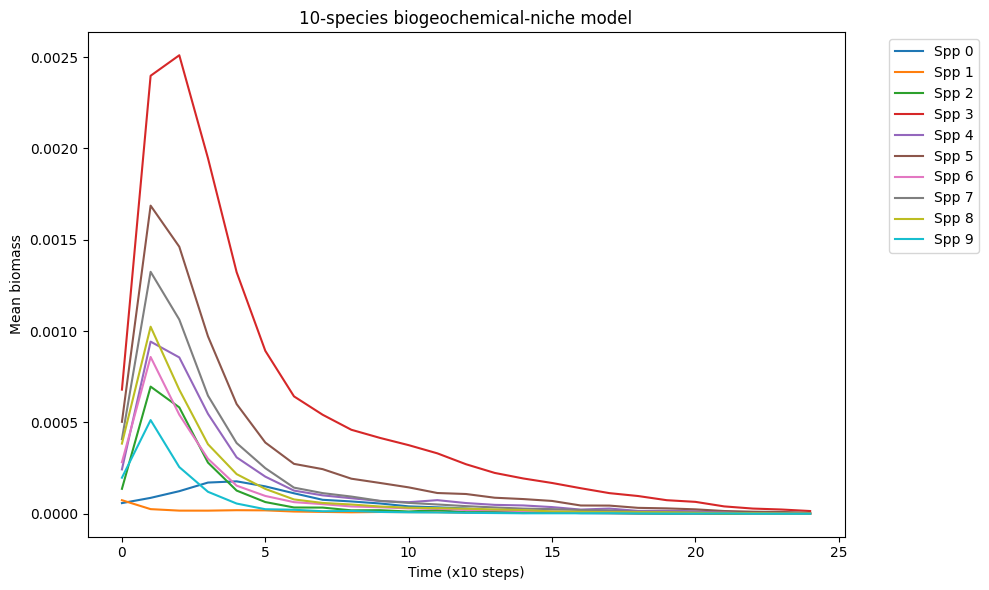

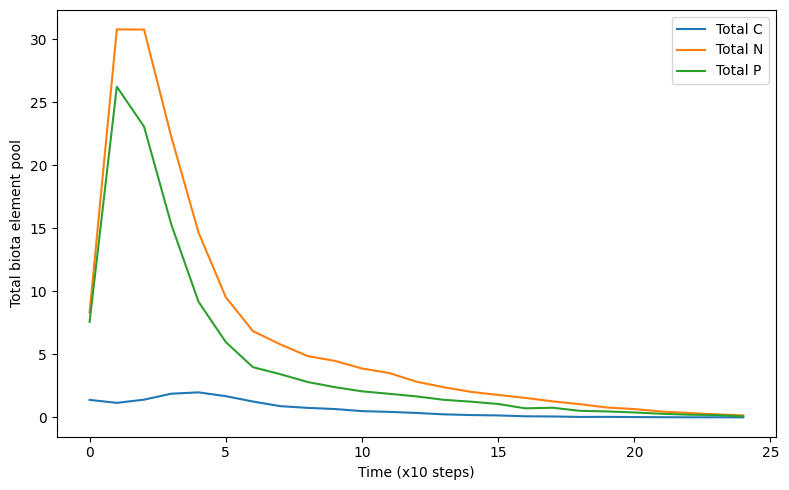

In [2]:
 Run this after a few steps
# 1. Get Average Soil Stats
soil_state = model.soil.numpy()
inorg = soil_state[:, :, 0:4]
avg_soil_center = np.mean(inorg[40:60, 40:60], axis=(0,1)) # Center region
avg_soil_edge   = np.mean(inorg[0:20, 0:20], axis=(0,1))   # Edge region

# 2. Get Your Species Niche Center
# (Assuming Species 0)
my_niche = model.niche_centers.numpy()[0]
# Note: my_niche is [C, N, P, K, O], so nutrients are indices 1-4
my_niche_nutrients = my_niche[1:5]

print("--- DIAGNOSTIC ---")
print(f"My Niche Ideal:  N={my_niche_nutrients[0]:.2f}, P={my_niche_nutrients[1]:.2f}")
print(f"Soil (Center):   N={avg_soil_center[0]:.2f}, P={avg_soil_center[1]:.2f}")
print(f"Soil (Edge):     N={avg_soil_edge[0]:.2f},   P={avg_soil_edge[1]:.2f}")

In [1]:
plt.imshow(model.soil[:,:,1].numpy(), cmap='viridis')
plt.colorbar(label="Soil N")
plt.title("Soil Nitrogen Distribution")
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

Community map: biomass max used for scaling = 0.01491597
rgb_map min/max: 0.0 1.0


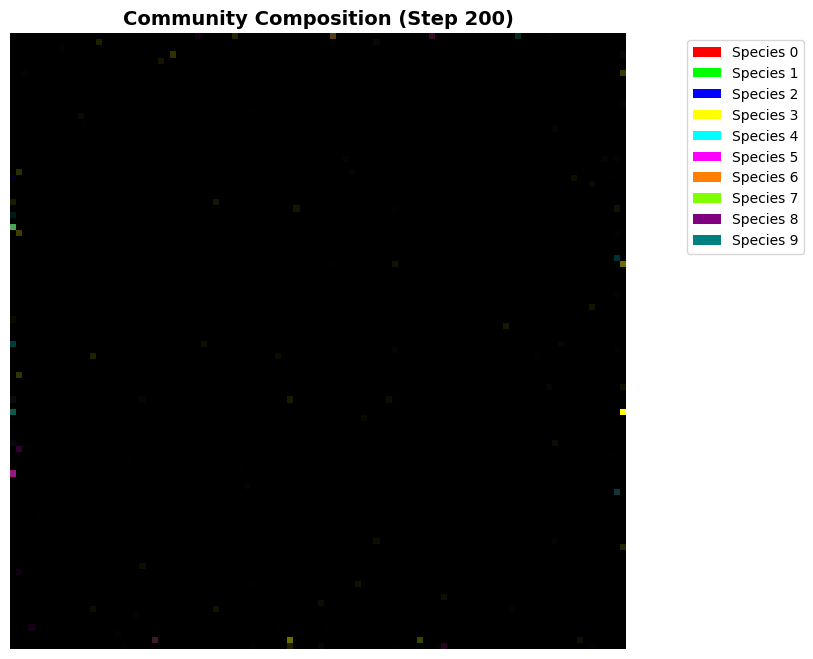

In [3]:
plot.plot_community_map(model.get_state(), N, timepoint="(Step 200)")

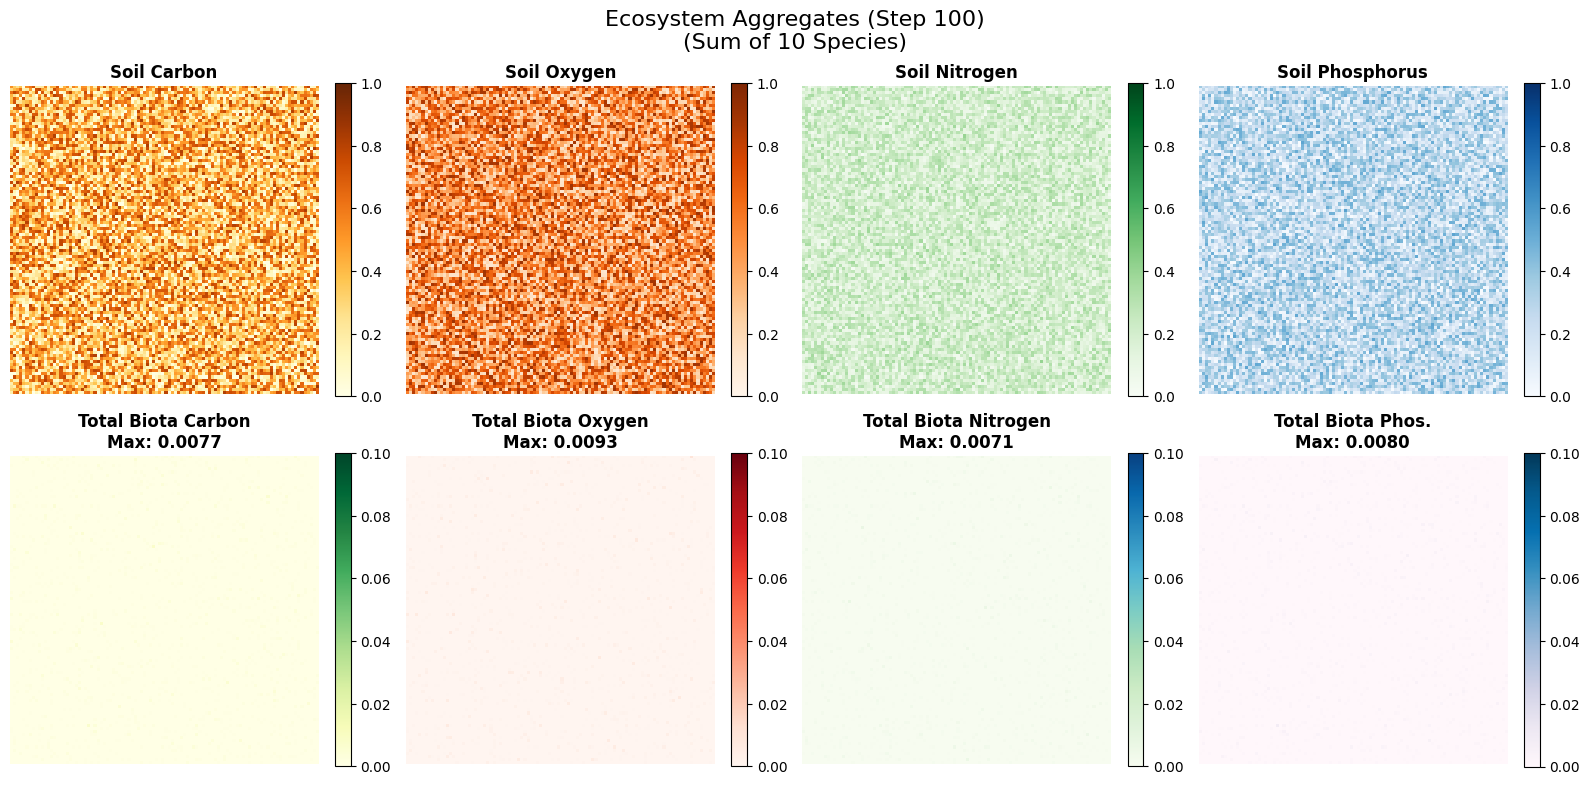

In [5]:
plot.plot_ecosystem_aggregate(model.get_state(), timepoint="(Step 100)")

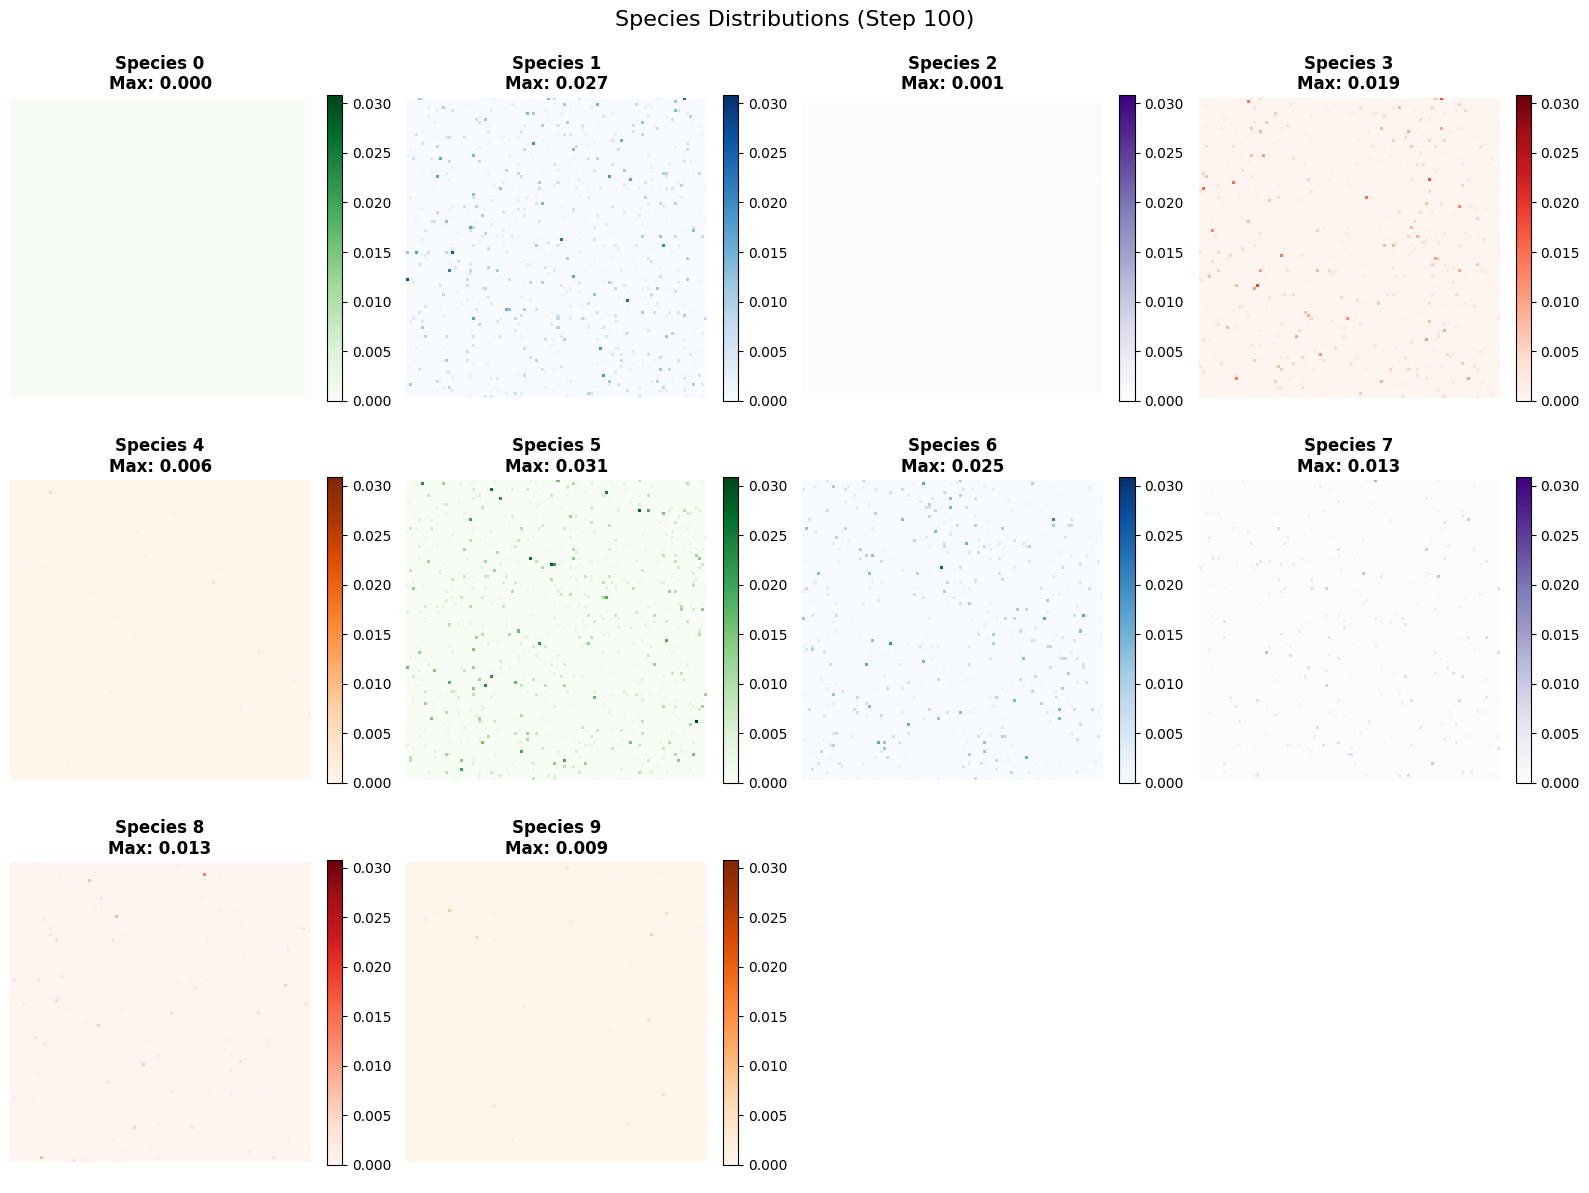

In [6]:
plot.plot_species_abundance(model.get_state(), timepoint="(Step 100)")